In [52]:
import pandas as pd
import numpy as np
import alienlab.utils
import matplotlib.pyplot as plt
from tkinter.filedialog import askopenfilename, askdirectory
import alienlab.plot
from alienlab.utils import *
from alienlab.regression_func import *
from   scipy import optimize
import os
import glob
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/optical_validation/"
p.figsize = (10,10)
p.fontsize = 18
p.fonttick = 12
%matplotlib inline
from statsmodels.regression import linear_model
from statsmodels.api import add_constant
from scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [11]:




def get_func(X, Y):
        Y = np.array([y for x, y in sorted(zip(X, Y))]) #preliminary sorting of the arrays along wavelength 
                                                            #(in case the graph in not properly ordered)
        X = np.sort(X)
        func = InterpolatedUnivariateSpline(X, Y) # interpolate given values with step 1 nm
        return func

def regression_affine(X, Y, details = True):
        Xreg = add_constant(X) #Add a constant to fit tan affine model

        model = linear_model.OLS(Y, Xreg) #Linear regression
        results = model.fit()
        [b, a] = results.params #parameters of the affine curve
        Yreg = a*X + b #regression curve

        return Yreg, a, b, results.summary()

def exp_decay(parameters,xdata):
    '''
    Calculate an exponetial decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0

def band_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H * (xdata * tau) /(1 + (xdata  * tau)**2) + a0

def low_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H*(xdata * tau)**2 /(1 + (xdata * tau)**2) + a0

def high_pass(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return H /(1 + (xdata * tau)**2) + a0

def sigmoid(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    t0 = parameters[3]
    return A * (1 / (1 + np.exp(-(xdata-t0)/tau))) + y0

def amplitude(parameters, xdata):
    
    H = parameters[0]
    tau = parameters[1]
    a0 = parameters[2]
    
    return (H /(1 + (xdata * tau)**2))**0.5 + a0

def residuals(parameters,x_data,y_observed,func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed


def averaging(measured_signal, 
                time_array, window, 
                do_binning = True):

    average_output = mvgavg(measured_signal, window, axis = 1, binning = do_binning)
    downscaled_time = time_array[window//2 :: window] 
    #todo: if binning == False, time array
    return average_output, downscaled_time    

def lock_in(self, measured_signal, 
            time_array, 
            frequency, phase_shift):
    cos_ref = np.cos(2*np.pi * frequency * time_array - phase_shift)
    cos_ref = np.stack([cos_ref] * measured_signal.shape[0])
    sin_ref = np.sin(2*np.pi * frequency * time_array - phase_shift)
    sin_ref = np.stack([sin_ref] * measured_signal.shape[0])
    cos_lock = 2 * np.multiply(measured_signal, cos_ref)
    sin_lock =  2 * np.multiply(measured_signal, sin_ref)
    radius_lock = np.sqrt(sin_lock.mean(axis = 1)**2 + cos_lock.mean(axis = 1)**2)
    phase_lock = np.arctan(sin_lock.mean(axis = 1)/cos_lock.mean(axis = 1))
    return sin_lock, cos_lock, radius_lock, phase_lock


def make_fit(x0, time_transition, fluo_transition):
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time_transition, fluo_transition, sigmoid))
    parameters_estimated = OptimizeResult.x

    y_data_predicted = sigmoid(parameters_estimated, time_transition)
    return parameters_estimated, y_data_predicted


### Jump response high

In [14]:
#file = askopenfilename()
file = glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/2021-08-10_18_15_LED_dynamics/*.csv")[0]
#file = "G:/DREAM/from_github/PAMFluo/Experiments/2021-04-16_10_43_LED_dynamics/2021-04-16_10_43_output_plot.csv"
#askopenfilename()
print(file)

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-10_18_15_LED_dynamics\2021-08-10_18_15_output_plot.csv


C:\Users\Alienor\AppData\Local\Temp\ipykernel_24532\3065724963.py:61: RuntimeWarning: overflow encountered in exp
  return A * (1 / (1 + np.exp(-(xdata-t0)/tau))) + y0


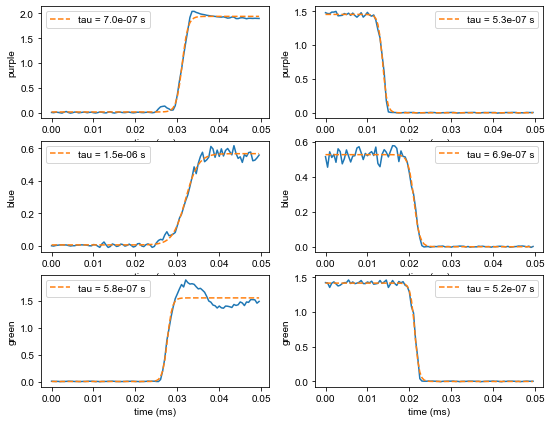

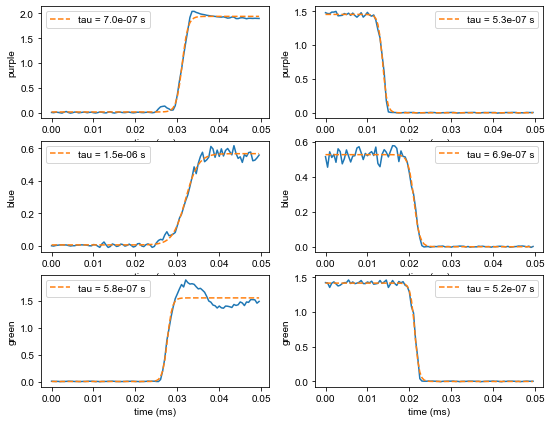

<Figure size 432x288 with 0 Axes>

In [15]:
headers, data = pandas_to_arrays(file)

intensity = 0
fluorescence = 1
arduino_blue = 2
arduino_green = 3
arduino_purple = 4
detector = ["intensity", "fluorescence", "arduino_blue", "arduino_green", "arduino_purple"]

sample_rate = 2e6


output = np.array(data[2::2])

#high_power 500
NI_curves = {}
d = 100
x0 = [0.01,0.01,0.01, 4]
NI_curves[arduino_purple] = {}
M = 59936
curve = output[:, M-d//2:M+d//2]
NI_curves[arduino_purple]["up_y"] = curve
M = 99900
NI_curves[arduino_purple]["down_y"] = output[:, M-d//2:M+d//2]

NI_curves[arduino_blue] = {}
M = 139854
NI_curves[arduino_blue]["up_y"] = output[:, M-d//2:M+d//2]
M = 179805
NI_curves[arduino_blue]["down_y"] = output[:, M-d//2:M+d//2]

NI_curves[arduino_green] = {}
M = 239736
NI_curves[arduino_green]["up_y"] = output[:, M-d//2:M+d//2]
M = 279700
NI_curves[arduino_green]["down_y"] = output[:, M-d//2:M+d//2]

"""
d = 3000
x0 = [0.01,0.01,0.01, 4]
NI_curves[arduino_purple] = {}
curve = output[:, 59500:59500+d]
NI_curves[arduino_purple]["up_y"] = curve
NI_curves[arduino_purple]["down_y"] = output[:, 99500:99500+d]

NI_curves[arduino_blue] = {}
NI_curves[arduino_blue]["up_y"] = output[:, 139500:139500+d]
NI_curves[arduino_blue]["down_y"] = output[:, 179500:179500+d]

NI_curves[arduino_green] = {}
NI_curves[arduino_green]["up_y"] = output[:, 239500:239500+d]
NI_curves[arduino_green]["down_y"] = output[:, 279500:279500+d]   
"""
fig, axs = plt.subplots(3,2, figsize=(9,7))
for j, part in enumerate(["up_y", "down_y"]):
   
    for i, k in enumerate(NI_curves.keys()):
        MPPC_intensity = NI_curves[k][part][intensity]
        L = len(MPPC_intensity)
        x_axis = np.linspace(0, L-1, L)/sample_rate*1e3
        axs[i][j].set_xlabel("time (ms)")
        axs[i][j].set_ylabel(detector[k][8:])
        axs[i][j].plot(x_axis, MPPC_intensity)#, label = detector[k])
        param, pred = make_fit(x0, x_axis, MPPC_intensity)
        axs[i][j].plot(x_axis, pred, "--", label = "tau = %0.1e s"%np.abs(1e-3*param[1]))

        arduino_intensity = NI_curves[k][part][k]
        #axs[i].plot(x_axis, arduino_intensity * MPPC_intensity.max()/arduino_intensity.max(), label = "arduino")


        fluo_intensity = NI_curves[k][part][fluorescence]
        #axs[i].plot(x_axis, fluo_intensity * MPPC_intensity.max()/fluo_intensity.max(), label = "fluorescence")
        #param, pred = make_fit(x0, x_axis, fluo_intensity)
        #axs[i].plot(x_axis, pred, "--", label = param[1])
        axs[i][j].legend() 
        
        
p.save_name = "high_500"
p.saving(fig)

# Jump response low

In [17]:
#file = askopenfilename()
file = glob.glob("G:/DREAM/from_github/PAMFluo/Experiments/2021-08-10_18_19_LED_dynamics/*.csv")[0]



#"G:/DREAM/from_github/PAMFluo/Experiments/2021-04-16_10_43_LED_dynamics/2021-04-16_10_43_output_plot.csv"
#askopenfilename()
print(file)

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-10_18_19_LED_dynamics\2021-08-10_18_19_output_plot.csv


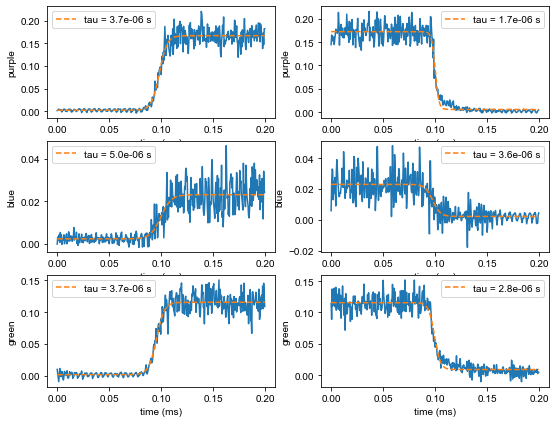

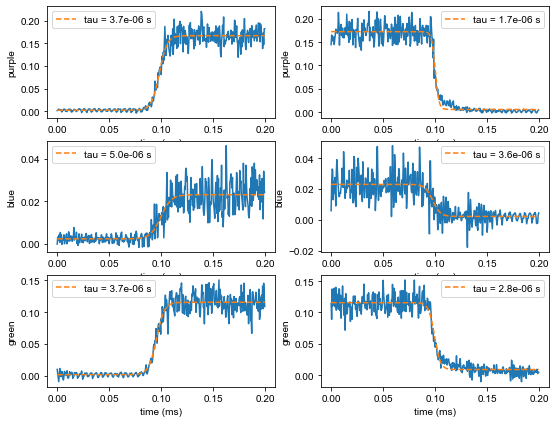

<Figure size 432x288 with 0 Axes>

In [18]:
headers, data = pandas_to_arrays(file)

intensity = 0
fluorescence = 1
arduino_blue = 2
arduino_green = 3
arduino_purple = 4
detector = ["intensity", "fluorescence", "arduino_blue", "arduino_green", "arduino_purple"]

sample_rate = 2e6


output = np.array(data[2::2])

#high_power 500
NI_curves = {}
d = 400
x0 = [0.01,0.001,0.01, 0.1]
NI_curves[arduino_purple] = {}
M = 60780
curve = output[:, M-d//2:M+d//2]
NI_curves[arduino_purple]["up_y"] = curve
M = 99881
NI_curves[arduino_purple]["down_y"] = output[:, M-d//2:M+d//2]

NI_curves[arduino_blue] = {}
M = 140663
NI_curves[arduino_blue]["up_y"] = output[:, M-d//2:M+d//2]
M = 179805
NI_curves[arduino_blue]["down_y"] = output[:, M-d//2:M+d//2]

NI_curves[arduino_green] = {}
M = 239783
NI_curves[arduino_green]["up_y"] = output[:, M-d//2:M+d//2]
M = 279700
NI_curves[arduino_green]["down_y"] = output[:, M-d//2:M+d//2]

"""
d = 3000
x0 = [0.01,0.01,0.01, 4]
NI_curves[arduino_purple] = {}
curve = output[:, 59500:59500+d]
NI_curves[arduino_purple]["up_y"] = curve
NI_curves[arduino_purple]["down_y"] = output[:, 99500:99500+d]

NI_curves[arduino_blue] = {}
NI_curves[arduino_blue]["up_y"] = output[:, 139500:139500+d]
NI_curves[arduino_blue]["down_y"] = output[:, 179500:179500+d]

NI_curves[arduino_green] = {}
NI_curves[arduino_green]["up_y"] = output[:, 239500:239500+d]
NI_curves[arduino_green]["down_y"] = output[:, 279500:279500+d]   
"""
fig, axs = plt.subplots(3,2, figsize=(9,7))
for j, part in enumerate(["up_y", "down_y"]):
   
    for i, k in enumerate(NI_curves.keys()):
        MPPC_intensity = NI_curves[k][part][intensity]
        L = len(MPPC_intensity)
        x_axis = np.linspace(0, L-1, L)/sample_rate*1e3
        axs[i][j].set_xlabel("time (ms)")
        axs[i][j].set_ylabel(detector[k][8:])
        axs[i][j].plot(x_axis, MPPC_intensity)#, label = detector[k])
        param, pred = make_fit(x0, x_axis, MPPC_intensity)
        axs[i][j].plot(x_axis, pred, "--", label = "tau = %0.1e s"%np.abs(1e-3*param[1]))

        arduino_intensity = NI_curves[k][part][k]
        #axs[i].plot(x_axis, arduino_intensity * MPPC_intensity.max()/arduino_intensity.max(), label = "arduino")


        fluo_intensity = NI_curves[k][part][fluorescence]
        #axs[i].plot(x_axis, fluo_intensity * MPPC_intensity.max()/fluo_intensity.max(), label = "fluorescence")
        #param, pred = make_fit(x0, x_axis, fluo_intensity)
        #axs[i].plot(x_axis, pred, "--", label = param[1])
        axs[i][j].legend() 
        
        
p.save_name = "low_5"
p.saving(fig)

### Intensity response

In [23]:
#directory = askdirectory(initialdir = "G:/DREAM/from_github/PAMFluo/Experiments")
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-09_10_32_bode_diagram/"
print(directory)


G:/DREAM/from_github/PAMFluo/Experiments/2021-08-09_10_32_bode_diagram/


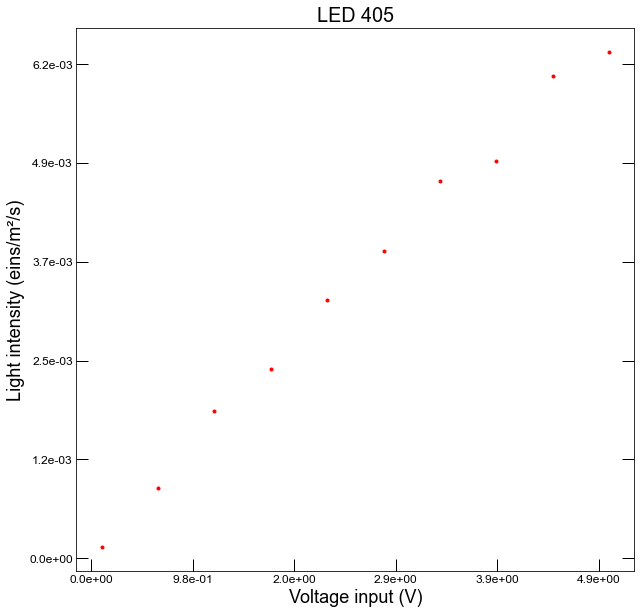

<Figure size 432x288 with 0 Axes>

In [24]:
file_intensity = glob.glob(directory + '/*Light_intensity_405.csv')[0]
file_voltage =  glob.glob(directory + '/*Detector_response_curve_purple.csv')[0]
headers, data = pandas_to_arrays(file_intensity)
mppc_voltage = data[1]
intensity = data[2]
headers, data = pandas_to_arrays(file_voltage)
input_voltage = data[1]
#func = get_func(data[1], data[2])
p.label_list = headers[1::2]
p.majorFormatterx = "%0.1e"
p.majorFormattery = "%0.1e"

p.title = "LED 405"
p.xlabel = "Voltage input (V)"
p.ylabel = "Light intensity (eins/m²/s)"
p.marker_list = [".", ""]
p.linestyle_list = ["", "-"]
p.ylog = ''
fig = p.plotting(input_voltage, intensity)
p.save_name = "Light_intensity_405"
p.saving(fig)
x = 1

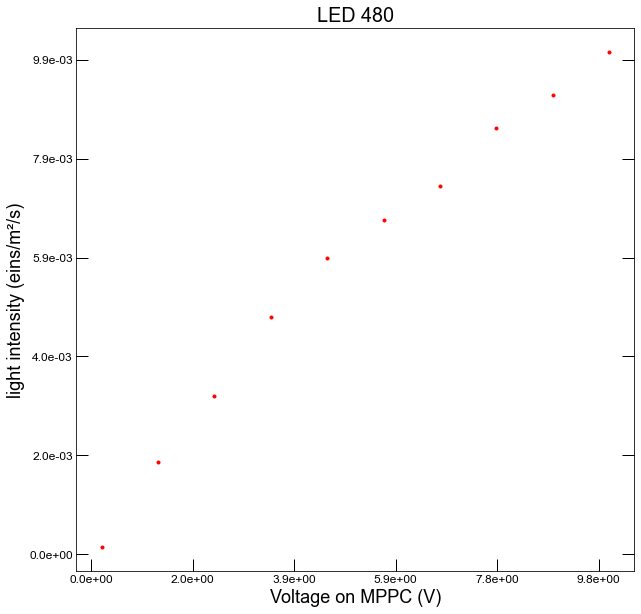

<Figure size 432x288 with 0 Axes>

In [25]:

file_intensity = glob.glob(directory + '/*Light_intensity_480.csv')[0]
file_voltage =  glob.glob(directory + '/*Detector_response_curve_blue.csv')[0]
headers, data = pandas_to_arrays(file_intensity)
mppc_voltage = data[1]
intensity = data[2]
headers, data = pandas_to_arrays(file_voltage)
input_voltage = data[1]
p.label_list = headers[1::2]
p.majorFormatterx = "%0.1e"
p.majorFormattery = "%0.1e"

p.title = "LED 480"
p.xlabel = "Voltage on MPPC (V)"
p.ylabel = "light intensity (eins/m²/s)"
p.marker_list = [".", ""]
p.linestyle_list = ["", "-"]
fig = p.plotting(input_voltage, intensity)
p.save_name = "light_intensity_480"
p.saving(fig)
x = 1

## Bode diagram

In [29]:
file = "G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_12_18_bode_diagram" 
#"G:/DREAM/from_github/PAMFluo/Experiments/2021-04-20_11_57_bode_diagram/2021-04-20_12_51_bode_plot_fluo.csv"
#askopenfilename()
print(file)

#"G:/DREAM/from_github/CIFRE_DREAM/REF_EXP/2020-07-09_16_38_Bode_Diagram_no_DO/2020-07-09_16_42_bode_plot_fluo.csv"

G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_12_18_bode_diagram


cut-off sin:  0.6593633513814389
cut-off cos:  0.4031464996342914
cut-off radius: 1.1726759860377591


C:\Users\Alienor\AppData\Local\Temp\ipykernel_24532\3065724963.py:69: RuntimeWarning: invalid value encountered in sqrt
  return (H /(1 + (xdata * tau)**2))**0.5 + a0


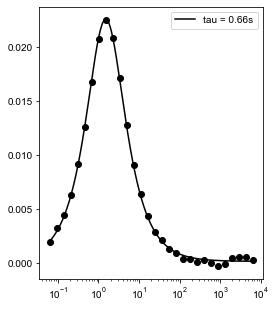

<Figure size 432x288 with 0 Axes>

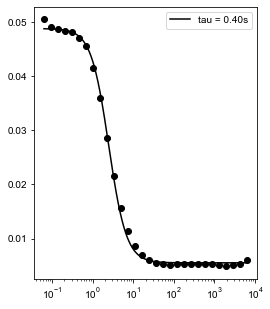

<Figure size 432x288 with 0 Axes>

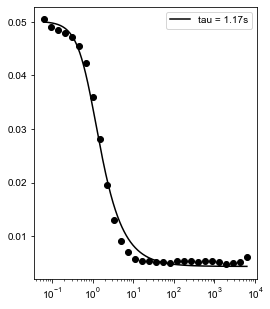

<Figure size 432x288 with 0 Axes>

In [27]:

file_bode =  glob.glob(file + '/*plot_fluo.csv')[0]

headers, data = pandas_to_arrays(file_bode)


x0 = [0.1, 0.1, 0]
frequencies = data[1]
sin_lo = data[4]
cos_lo = data[2]
radius = data[6]
pulse = 2 * np.pi * frequencies
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, sin_lo, band_pass)).x

fig = plt.figure(figsize =(4, 5))
tau_sin = parameters_estimated[1]
print("cut-off sin: ", tau_sin)
remake_x = 10**np.linspace(np.log(pulse.min())/np.log(10), np.log(pulse.max())/np.log(10), 1024)
sin_hat = band_pass(parameters_estimated, remake_x)
plt.plot(remake_x, sin_hat, "k", label = "tau = %0.2fs"%tau_sin)
plt.plot(pulse, sin_lo, 'ok')
plt.xscale('log')
#plt.title('Cos lock-in')
plt.legend()
p.save_name = "cos_lockin"
p.saving(fig)


fig = plt.figure(figsize =(4, 5))
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, cos_lo, low_pass)).x
tau_cos = parameters_estimated[1]
print("cut-off cos: ", tau_cos)
cos_hat = low_pass(parameters_estimated, remake_x)
plt.plot(remake_x, cos_hat, "k", label ="tau = %0.2fs"%tau_cos)
plt.plot(pulse, cos_lo, 'ok')
plt.xscale('log')
#plt.title('Sin lock-in')
plt.legend()
p.save_name = "sin_lockin"
p.saving(fig)

fig = plt.figure(figsize =(4, 5))
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                    args = (pulse, radius, amplitude)).x
tau_radius = parameters_estimated[1]
print("cut-off radius:", tau_radius)
radius_hat = amplitude(parameters_estimated, remake_x)
plt.plot(remake_x, radius_hat, "k",  label= "tau = %0.2fs"%tau_radius)
plt.plot(pulse, radius, 'ok')
plt.xscale('log')
#plt.title('Amplitude lock-in')
plt.legend()
p.save_name = "amplitude_lockin"
p.saving(fig)
plt.show()


In [30]:
headers, data = pandas_to_arrays(file)

p.title = 'Bode plot'
p.xlabel = 'Frequency'
p.ylabel = 'Amplitude'
p.y2label = 'Phase'
p.label_list = ['amplitude', 'sin', 'cos', "amplitude_fit", "sin_fit", "cos_fit"]
p.label2_list = ['phase']
p.marker_list = [".", ".", ".", "", "", ""]
p.linestyle_list = ["", "", "", "-", "-", "-"]
p.color_list = ["r", "g", "b"]*2
p.legend=True

p.ylog = 'semilogx'
p.y2log = 'semilogx'
p.majorFormatterx = "%0.2e"
p.xval = data[1:6:2]*2
p.yval = [radius, sin_lo, cos_lo, radius_hat, sin_hat, cos_hat]
p.x2val = data[7]
p.y2val = data[8]
fig = p.coplotting()
p.save_name = "bode_plot_fluo"
p.saving(fig)
x = 1

PermissionError: [Errno 13] Permission denied: 'G:/DREAM/from_github/PAMFluo/Experiments/2022-01-25_12_18_bode_diagram'

# Spectral content

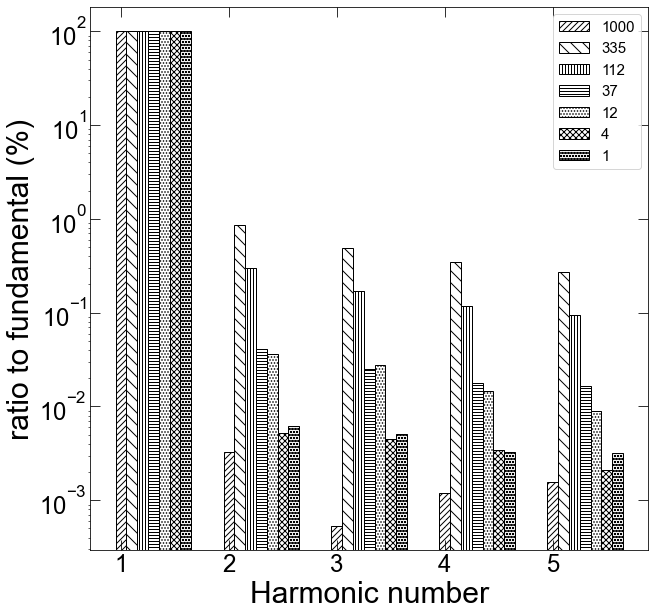

In [64]:
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2022-01-20_14_19_spectral_content/"
file = np.load(directory + "/data_dict.npy", allow_pickle = True).item()
plt.figure(figsize = (10, 10))
fill =  [ "////" , "\\\\" , "||||" , "----" , "...." , "xxxx", "oooo", "O"]

for i, k in enumerate(list(file.keys())[::3]):
    #Y = file[k]["intensity"]
    Y = file[k]["input"]

    Y = Y[10:60:10]/Y[10]
    X = np.linspace(1, 5, 5)
    Y = 100*Y
    plt.bar(X+0.1*i, Y, width=0.1, color = "w", edgecolor = "k", log=True, label = "%d"%k, hatch = fill[i])
    plt.ylabel("ratio to fundamental (%)", fontsize = 30)
    plt.xlabel("Harmonic number", fontsize=30)
    #plt.semilogy(Y)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )

plt.legend(prop={'size': 15})
#plt.savefig(p.save_folder + "/specral_content_intensity.pdf")#"input"
plt.savefig(p.save_folder + "/specral_content_input.pdf")#"input"

In [63]:
file[1000.0]

{'intensity': array([0.        , 3.22419861, 4.05236657, ..., 2.70751235, 2.32608462,
        2.05260258]),
 'input': array([0.        , 0.03883388, 0.06095303, ..., 0.02549245, 0.07031068,
        0.09057246]),
 'output': array([[ 1.85781180e-01,  1.37338180e-01,  1.76874180e-01, ...,
          1.78749180e-01,  1.68435180e-01,  1.65466180e-01],
        [ 4.02137701e-01,  4.03856701e-01,  4.01043701e-01, ...,
          4.67297701e-01,  5.04800701e-01,  4.90736701e-01],
        [ 2.90101535e-03, -2.41098465e-03,  1.02601535e-03, ...,
         -3.79984650e-04,  4.01015350e-04, -1.31698465e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'time'

### Homogeneity of the response

Voltage 2.5 for blue, oscillating between 0 and 2.5 for purple  
2.5 blue -> 1500µeins/m²/s  
2.5 purple -> 900 µeins/m²/s  
expected log(tau) around 0.5  

In [36]:
Z_V = {405:{}, 480:{}}
S_V = {405:{}, 480:{}}

In [37]:
#directory = askdirectory(initialdir = "G:/DREAM/from_github/PAMFluo/Experiments")
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_11_56_D2_calib_video"

#directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_16_45_D2_calib_video_0V/"
print(directory)

G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_11_56_D2_calib_video


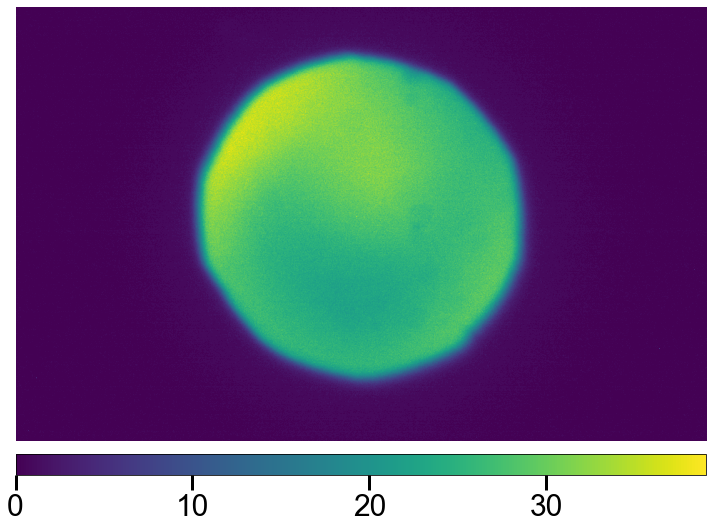

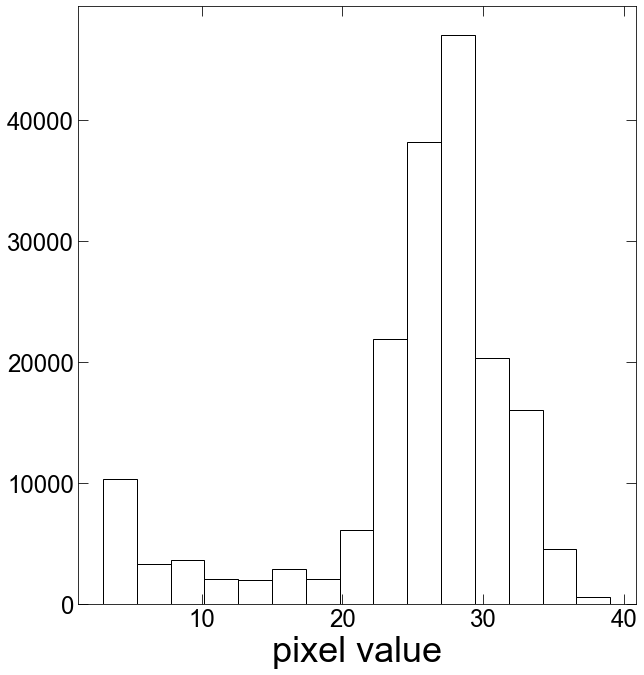

In [40]:
import tifffile as tiff
f = plt.figure(figsize = (10,8))

file = glob.glob(directory + "/video.tiff")[0]
video = tiff.imread(file)
imvid = video[0]
image = plt.imshow(imvid)
plt.axis("off")
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
cbar.ax.tick_params(labelsize=30, size = 15, width = 3)
f.tight_layout()

plt.savefig(p.save_folder + "/intensity_camera.pdf")

fig = plt.figure(figsize = (10,11))
ax = plt.gca()
plt.xlabel("pixel value", fontsize = 36)
ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
_, bins, _ = plt.hist(imvid[imvid>2], 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")
plt.savefig(p.save_folder + "/histogram_intensity_camera.pdf")


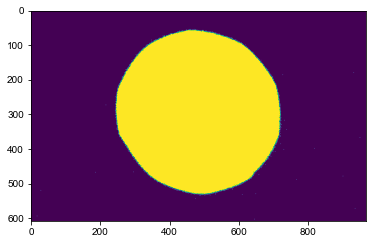

In [39]:
plt.imshow(video[10]>2)

In [42]:
file = glob.glob(directory + "/*405.npy")[0]
I_405 = np.load(file)
#tau_405_map[np.log(tau_405_map) > 1] = 1
#tau_405_map[np.log(tau_405_map) < 0] = 1
#plt.imshow(np.log(tau_405_map))
#plt.colorbar()
#plt.show()

In [43]:
file = glob.glob(directory + "/*480.npy")[0]
I_480 = np.load(file)
#tau_480_map[np.log(tau_480_map) > 1] = 1
#tau_480_map[np.log(tau_480_map) < 0] = 1
#plt.imshow(np.log(tau_480_map))
#plt.colorbar()
#plt.show()

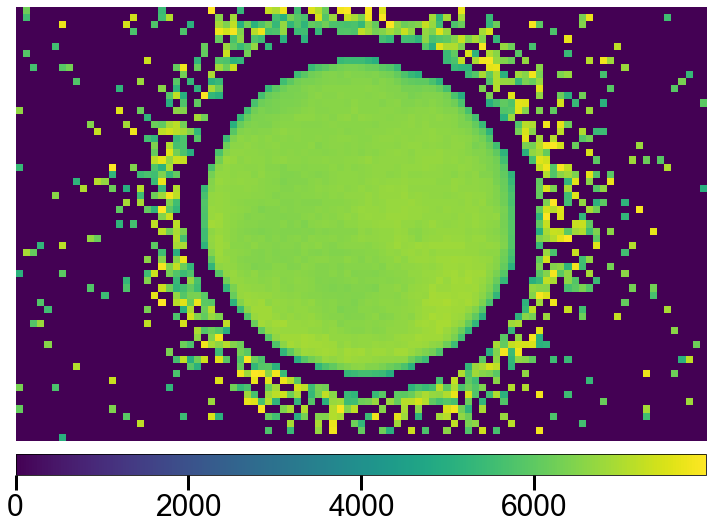

In [44]:
I_480[I_480> 8000]=0
I_480[I_480< 5000]=0
f = plt.figure(figsize = (10,8))
image = plt.imshow((I_480))
plt.axis("off")
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
cbar.ax.tick_params(labelsize=30, size = 15, width = 3)
f.tight_layout()
plt.savefig(p.save_folder + "/tau_480_map.pdf")

Z_V[480][0] = np.mean(I_480[I_480!=0])
S_V[480][0] = np.std(I_480[I_480!=0])

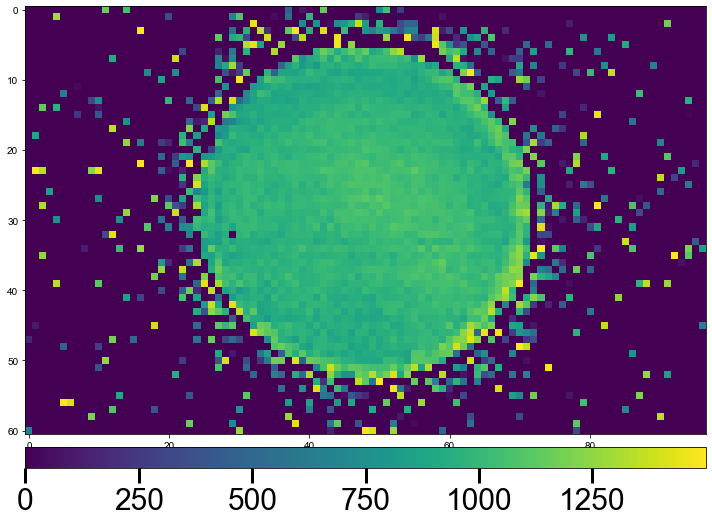

In [54]:

I_405[I_405<0]=0
I_405[I_405>1500]=0
f = plt.figure(figsize = (10,8))
image = plt.imshow((I_405))
#plt.axis("off")

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
cbar.ax.tick_params(labelsize=30, size = 15, width = 3)
f.tight_layout()
plt.savefig(p.save_folder + "/tau_405_map.pdf")
Z_V[405][0] = np.mean(I_405[I_405!=0])
S_V[405][0] = np.std(I_405[I_405!=0])

image map of the values of tau_480 and tau_405

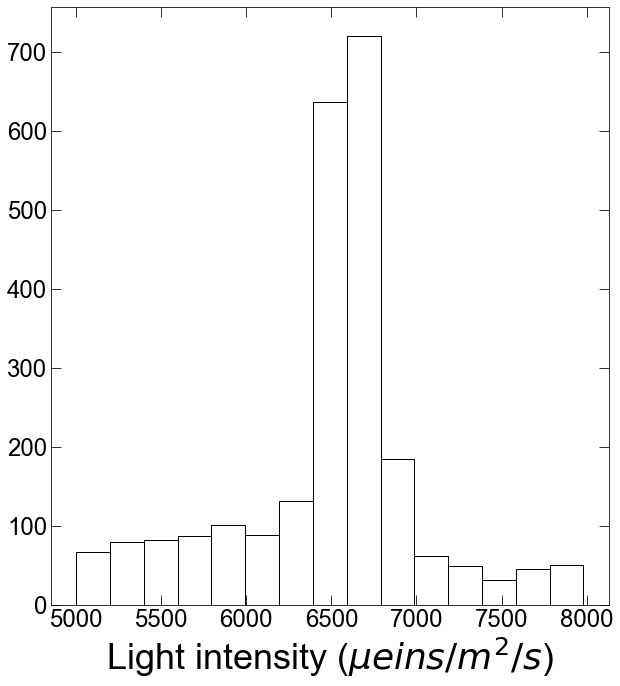

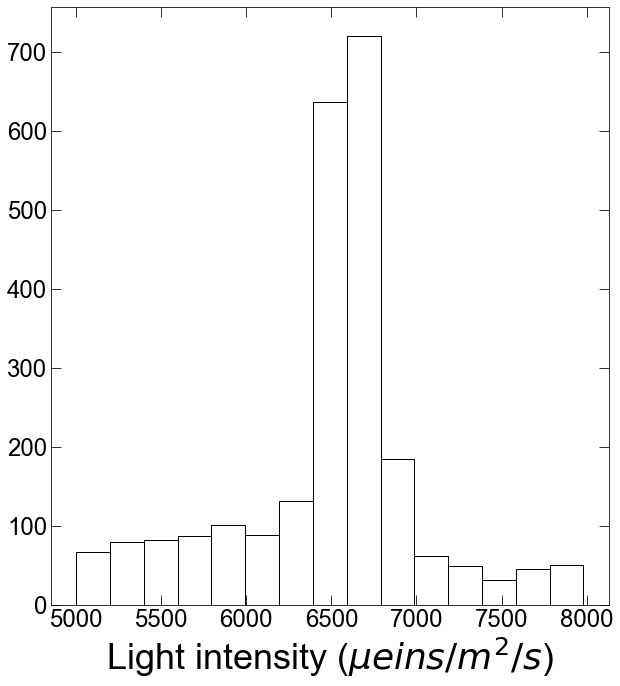

<Figure size 432x288 with 0 Axes>

In [55]:
I_480_distrib = I_480[I_480>1].flatten()

fig = plt.figure(figsize = (10,11))
ax = plt.gca()

p.save_name = "tau_480_hist"
p.extension = ".pdf"
plt.xlabel(r"Light intensity ($\mu eins /m^2/s$)", fontsize = 36)
plt.ylabel("", fontsize = 36)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
_, bins, _ = plt.hist(I_480_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

p.saving(fig)



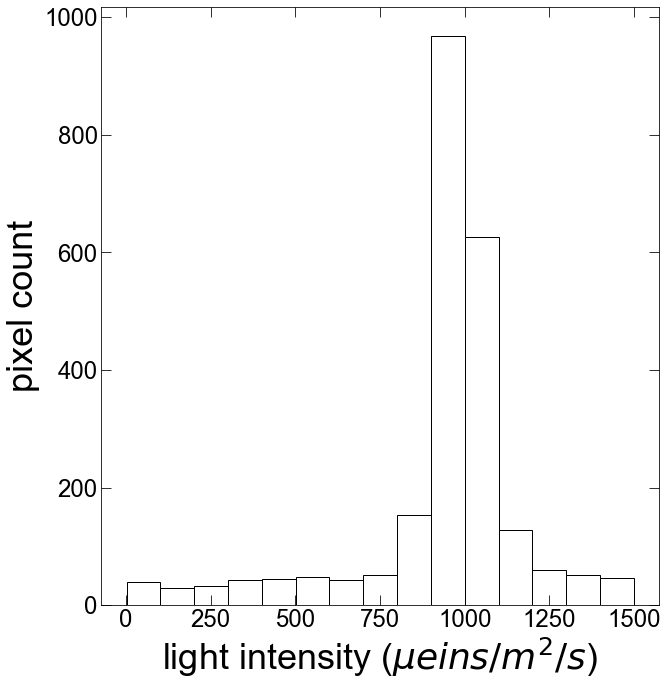

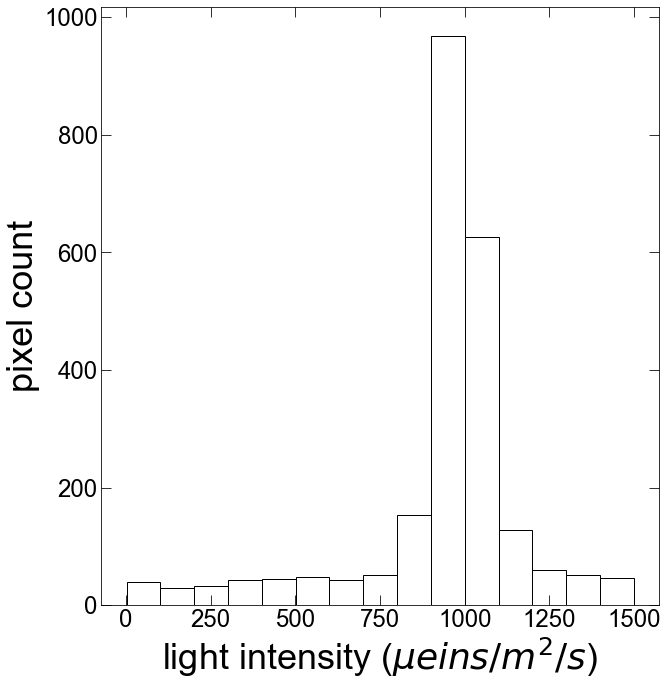

<Figure size 432x288 with 0 Axes>

In [56]:
I_405_distrib = I_405[I_405>1].flatten()


fig = plt.figure(figsize = (10,11))
ax = plt.gca()
p.save_name = "tau_405_hist"
p.extension = ".pdf"
plt.xlabel(r"light intensity ($\mu eins /m^2/s$)", fontsize = 36)
plt.ylabel("pixel count", fontsize = 36)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
_, bins, _ = plt.hist(I_405_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

p.saving(fig)



6612.62143112539
90.96797880887692


(<Figure size 360x360 with 1 Axes>,
     radius lalala  standard deviation lalala
 0               0                   0.000000
 1               1                  17.606490
 2               2                  25.826915
 3               3                  32.277027
 4               4                  36.690154
 5               5                  39.632888
 6               6                  40.873167
 7               7                  42.245304
 8               8                  41.235184
 9               9                  40.899401
 10             10                  40.194126
 11             11                  40.681522
 12             12                  41.701820
 13             13                  41.513420
 14             14                  42.259683
 15             15                  42.795450
 16             16                  43.004022
 17             17                  43.427687
 18             18                  44.214850
 19             19                  45.00445

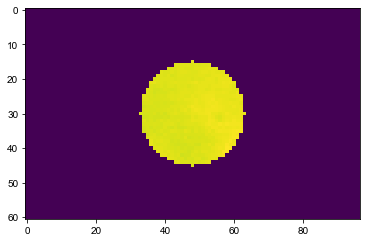

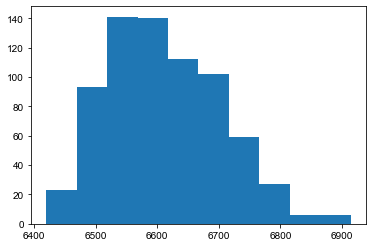

<Figure size 432x288 with 0 Axes>

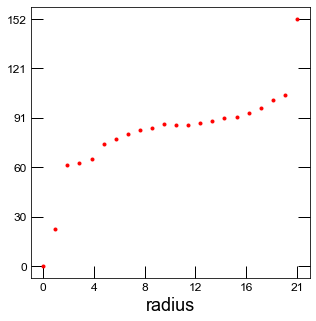

<Figure size 432x288 with 0 Axes>

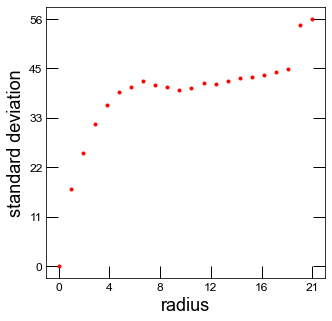

<Figure size 432x288 with 0 Axes>

In [66]:
s = I_480.shape
# Function definition for creating masks
def circle_index(X, Y, center, radius):
    dist = (X - center[0])**2 + (Y - center[1])**2
    return dist <= radius**2

radius = 15
mask = circle_index(*np.ogrid[0:s[0], 0:s[1]], center=[s[0]//2,s[1]//2], radius=radius)
masked_im = (I_480 * mask)
plt.imshow(masked_im)

plt.figure()
plt.hist(I_480[mask])
print(np.mean(I_480[mask]))
print(np.std(I_480[mask]))

plt.figure()
r480 = []
std480 = []

r405 = []
std405 = []
for radius in range(22):#[3,5,10,15,20]:#25,30,35,40, 50, 60]:
    mask = circle_index(*np.ogrid[0:s[0], 0:s[1]], center=[s[0]//2,s[1]//2], radius=radius)
    r480.append(radius)
    std480.append(np.std(I_480[mask]))
    r405.append(radius)
    std405.append(np.std(I_405[mask]))
    """
    fig = plt.figure(figsize = (10,11))
    ax = plt.gca()
    p.save_name = "tau_480_hist"
    p.extension = ".pdf"
    plt.xlabel(r"light intensity ($\mu eins /m^2/s$)", fontsize = 36)
    plt.ylabel("pixel count", fontsize = 36)

    
    ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
    _, bins, _ = plt.hist(I_480[mask], 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")
    p.saving(fig)
    fig = plt.figure(figsize = (10,11))
    ax = plt.gca()
    p.save_name = "tau_405_hist"
    p.extension = ".pdf"
    plt.xlabel(r"light intensity ($\mu eins /m^2/s$)", fontsize = 36)
    plt.ylabel("pixel count", fontsize = 36)

    #plt.scatter(radius, np.std(I_480[mask])/np.mean(I_480[mask])*100, color = "k")
    ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
    _, bins, _ = plt.hist(I_405[mask*I_405>100], 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")
    p.saving(fig)
    """

p.label_list = ["lalala"]
p.majorFormatterx = "%0.1d"
p.majorFormattery = "%0.1d"
p.figsize=(5,5)
p.title = ""
p.xlabel = "radius"
p.ylabel = ""
p.marker_list = [".", ""]
p.linestyle_list = ["", "-"]
fig = p.plotting(np.array(r480), np.array(std480))
p.save_name = "light_480_dev"
p.saving(fig)

p.figsize=(5,5)

p.ylabel = "standard deviation"
fig = p.plotting(np.array(r405), np.array(std405))

p.save_name = "light_405_dev"
p.saving(fig)


## z-axis dependancy

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_16_48_D2_calib_video_40V


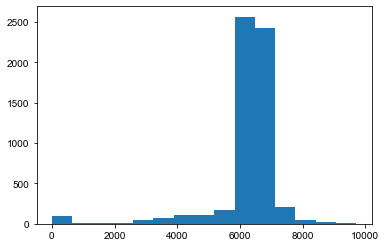

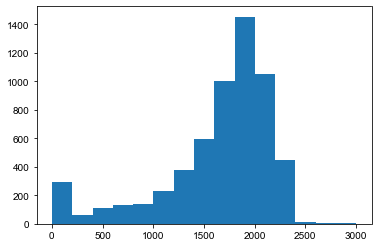

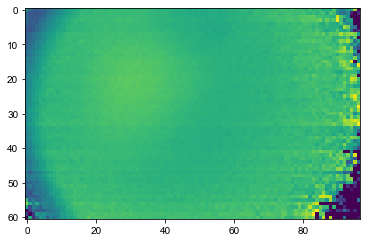

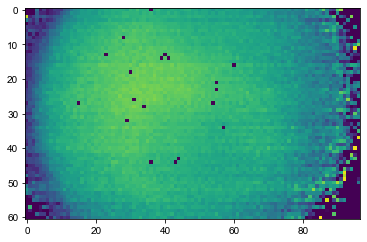

In [68]:
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_16_48_D2_calib_video_40V"
print(directory)
file = glob.glob(directory + "/*405.npy")[0]
I_405 = np.load(file)
file = glob.glob(directory + "/*480.npy")[0]
I_480 = np.load(file)
I_480[I_480> 1e4]=0
I_480[I_480< 0]=0
I_405[I_405<0]=0
I_405[I_405>2e4]=0
plt.figure()
I_480_distrib = I_480.flatten()
plt.hist(I_480_distrib, bins = 15)
plt.figure()
I_405_distrib = I_405.flatten()
plt.hist(I_405_distrib, bins = 15)

plt.figure()
plt.imshow(I_480)
plt.figure()
plt.imshow(I_405)
Z_V[480][40] = np.mean(I_480[I_480!=0])
Z_V[405][40] = np.mean(I_405[I_405!=0])

S_V[480][40] = np.std(I_480[I_480!=0])
S_V[405][40] = np.std(I_405[I_405!=0])

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_16_51_D2_calib_video_75V


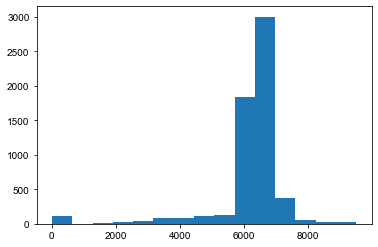

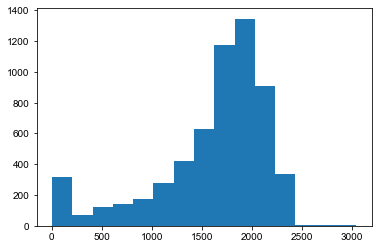

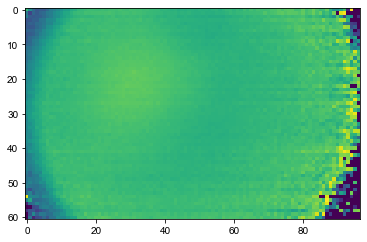

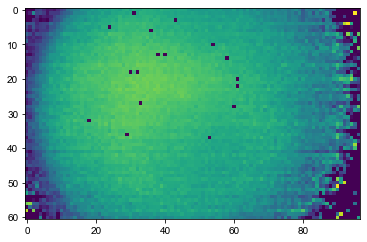

In [69]:
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_16_51_D2_calib_video_75V"
print(directory)
file = glob.glob(directory + "/*405.npy")[0]
I_405 = np.load(file)
file = glob.glob(directory + "/*480.npy")[0]
I_480 = np.load(file)
I_480[I_480> 1e4]=0
I_480[I_480< 0]=0
I_405[I_405<0]=0
I_405[I_405>2e4]=0
plt.figure()
I_480_distrib = I_480.flatten()
plt.hist(I_480_distrib, bins = 15)
plt.figure()
I_405_distrib = I_405.flatten()
plt.hist(I_405_distrib, bins = 15)
plt.figure()
plt.imshow(I_480)
plt.figure()
plt.imshow(I_405)
Z_V[480][75] = np.mean(I_480[I_480!=0])
Z_V[405][75] = np.mean(I_405[I_405!=0])
S_V[480][75] = np.std(I_480[I_480!=0])
S_V[405][75] = np.std(I_405[I_405!=0])

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_17_03_D2_calib_video_50um


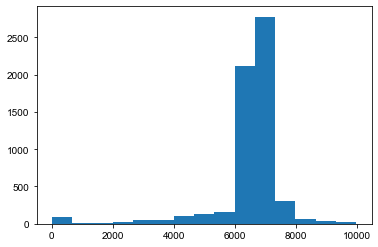

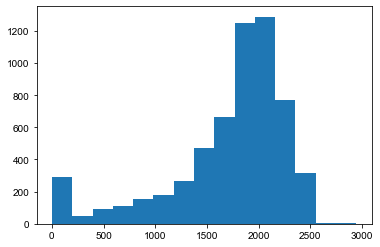

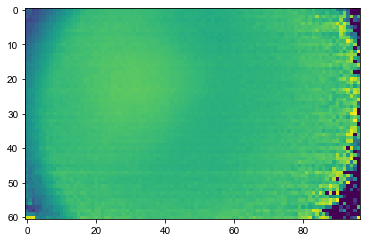

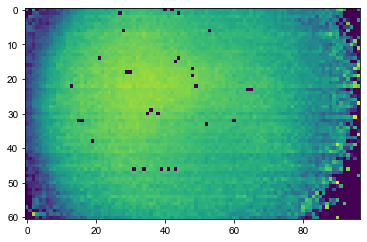

In [70]:

directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_17_03_D2_calib_video_50um"
print(directory)
file = glob.glob(directory + "/*405.npy")[0]
I_405 = np.load(file)
file = glob.glob(directory + "/*480.npy")[0]
I_480 = np.load(file)
I_480[I_480> 1e4]=0
I_480[I_480< 0]=0
I_405[I_405<0]=0
I_405[I_405>2e4]=0
plt.figure()
I_480_distrib = I_480.flatten()
plt.hist(I_480_distrib, bins = 15)
plt.figure()
I_405_distrib = I_405.flatten()
plt.hist(I_405_distrib, bins = 15)
plt.figure()
plt.imshow(I_480)
plt.figure()
plt.imshow(I_405)

Z_V[480]["50um"] = np.mean(I_480[I_480!=0])
Z_V[405]["50um"] = np.mean(I_405[I_405!=0])
S_V[480]["50um"] = np.std(I_480[I_480!=0])
S_V[405]["50um"] = np.std(I_405[I_405!=0])

G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_17_07_D2_calib_video_100um


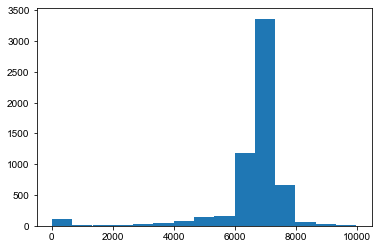

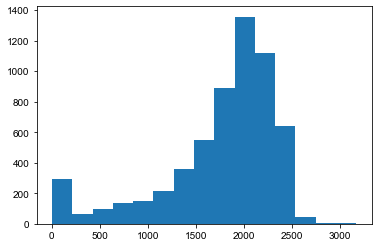

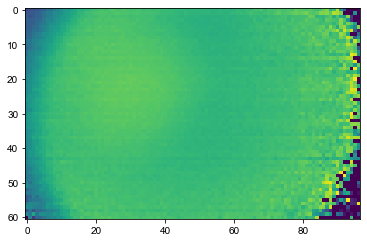

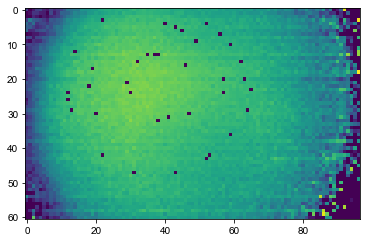

In [71]:
directory = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-25_17_07_D2_calib_video_100um"
print(directory)
file = glob.glob(directory + "/*405.npy")[0]
I_405 = np.load(file)
file = glob.glob(directory + "/*480.npy")[0]
I_480 = np.load(file)
I_480[I_480> 1e4]=0
I_480[I_480< 0]=0
I_405[I_405<0]=0
I_405[I_405>2e4]=0
plt.figure()
I_480_distrib = I_480.flatten()
plt.hist(I_480_distrib, bins = 15)
plt.figure()
I_405_distrib = I_405.flatten()
plt.hist(I_405_distrib, bins = 15)
plt.figure()
plt.imshow(I_480)
plt.figure()
plt.imshow(I_405)

Z_V[480]["100um"] = np.mean(I_480[I_480!=0])
Z_V[405]["100um"] = np.mean(I_405[I_405!=0])
S_V[480]["100um"] = np.std(I_480[I_480!=0])
S_V[405]["100um"] = np.std(I_405[I_405!=0])

In [72]:
S_V

{405: {0: 496.90684176722243,
  40: 563.2218389855939,
  75: 571.4410734165947,
  '50um': 584.1437289598426,
  '100um': 608.3445329902994},
 480: {0: 551.2665530908674,
  40: 1127.2301119167562,
  75: 1177.225380500104,
  '50um': 1173.2601567748402,
  '100um': 1190.132101833563}}

<ErrorbarContainer object of 3 artists>

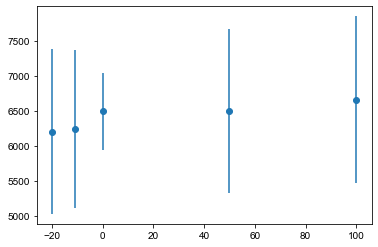

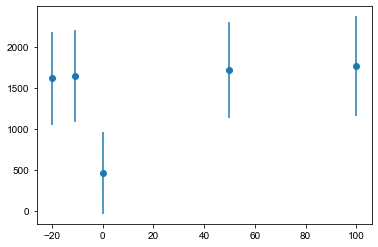

In [73]:
x = [0, -11, -20, 50, 100]
y = {480:[], 405:[]}
e = {480:[], 405:[]}

for k in Z_V.keys():
    dic = Z_V[k]
    for dist in dic.keys():
        y[k].append(dic[dist])
        e[k].append(S_V[k][dist])
        
plt.errorbar(x, y[480], yerr=e[480], fmt='o')
plt.figure()
plt.errorbar(x, y[405], yerr=e[405], fmt='o')


In [74]:
e[480]

[551.2665530908674,
 1127.2301119167562,
 1177.225380500104,
 1173.2601567748402,
 1190.132101833563]